Begin by using geoplotlib to plot all incidents of the three crime types [PROSTITUTION, DRUG/NARCOTIC, DRIVING UNDER THE INFLUENCE] on their own map using geoplotlib.kde(). This will give you an idea of how the varioius crimes are distributed across the city.

## 1. KNN

In [1]:
import pandas as pd
from IPython.display import display

csv = pd.read_csv('../data/SFPD_data.csv')
df = pd.DataFrame(csv)
#display(df.head())

knn_crimes = ['PROSTITUTION', 'DRUG/NARCOTIC', 'DRIVING UNDER THE INFLUENCE']
knn_data = df[df['Category'].isin(knn_crimes)]
knn_data = knn_data.filter(items=['Category','X','Y'])
display(knn_data.head())

Category           X          Y
11                DRUG/NARCOTIC -122.413354  37.769075
12                DRUG/NARCOTIC -122.413354  37.769075
31                DRUG/NARCOTIC -122.419520  37.764229
41                DRUG/NARCOTIC -122.419828  37.766674
61  DRIVING UNDER THE INFLUENCE -122.420692  37.790577

In [2]:
import geoplotlib
from geoplotlib.utils import BoundingBox
%matplotlib inline

def kde_plot(geo_data):
    #Ready for plotting
    print(crime+': KDE Map')
    geoplotlib.kde(geo_data,bw=3,binsize=0.5,cmap='jet') #hot
    bbox = BoundingBox(north=max(geo_data['lat']), #geo_data_for_plotting['lat']
                       west=min(geo_data['lon']), #geo_data_for_plotting['lon']
                       south=min(geo_data['lat']), #geo_data_for_plotting['lat']
                       east=max(geo_data['lon'])) #geo_data_for_plotting['lon']
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()
    
# Remove the outliers
knn_data = knn_data[knn_data['Y']!=90]

# Create a dictionary and put each crime's coordinates as a separate key,value pair and plot the KDE
geo_dict = {}
for crime in knn_crimes:
    geo_data_for_plotting = {"lat": [float(el) for el in list(knn_data[knn_data['Category']==crime]['Y'])],
                             "lon": [float(el) for el in list(knn_data[knn_data['Category']==crime]['X'])]}
    geo_dict[crime] = geo_data_for_plotting
    kde_plot(geo_dict[crime])

PROSTITUTION: KDE Map
('smallest non-zero count', 1.9901719039787654e-09)
('max count:', 20.919415074209297)


DRUG/NARCOTIC: KDE Map
('smallest non-zero count', 2.3856699135695406e-06)
('max count:', 65.426026571430398)


DRIVING UNDER THE INFLUENCE: KDE Map
('smallest non-zero count', 1.1928349567847703e-06)
('max count:', 1.7245697765363592)


Next, it's time to set up your model based on the actual data.
* You don't have to think a lot about testing/trainig and accuracy for this exercise. We're mostly interested in creating a map that's not too problematic. But do calculate the number of observations of each crime-type respectively. You'll find that the levels of each crime varies (lots of drug arrests, an intermediate amount of prostitiution registered, and very little drunk driving in the dataset). Since the algorithm classifies each point according to it's neighbors, what could a consequence of this imbalance in the number of examples from each class mean for your map?
* You can make the dataset 'balanced' by grabbing an equal number of examples from each crime category. How do you expect that will change the KNN result? In which situations is the balanced map useful - and when is the map that data in proportion to occurrences useful? Choose which map you will work on in the following.

In [3]:
#Let's define a function for plotting the dot map, as it will be used later
def dot_plot(geo_dict):
    colors = ['red', 'green', 'blue']

    for i,crime in enumerate(knn_crimes):
        # Create a legend
        print '%s\t ----->\t%d observations\t ----->\t%s' % (colors[i],len(geo_dict[crime]['lon']),crime)
        # Fit the map with dots
        geoplotlib.dot(geo_dict[crime], color=colors[i], point_size=2)

    # Create an BoundigBox for the limits of the map
    bbox = BoundingBox(north=max(geo_dict[crime]['lat']),
                       west=min(geo_dict[crime]['lon']),
                       south=min(geo_dict[crime]['lat']),
                       east=max(geo_dict[crime]['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()
    
dot_plot(geo_dict)

red	 ----->	16161 observations	 ----->	PROSTITUTION
green	 ----->	115124 observations	 ----->	DRUG/NARCOTIC
blue	 ----->	5302 observations	 ----->	DRIVING UNDER THE INFLUENCE


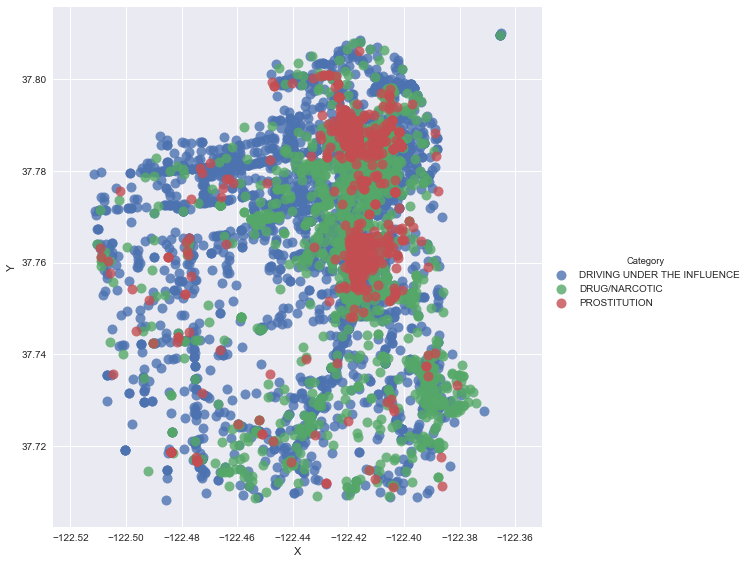

In [4]:
import seaborn as sns

num_samples = 3000 #Number of random samples to extract

# Randomly extract a balanced number of samples
balanced_df = pd.DataFrame(columns = ['Category','X','Y'])
for crime in knn_crimes:
    sample = knn_data[knn_data['Category']==crime].sample(n=num_samples)
    balanced_df = pd.concat([sample,balanced_df])
    
# Create a simple plot of the dataset before the classification
sns.lmplot('X', 'Y', data=balanced_df, fit_reg=False,hue="Category", size=8,scatter_kws={"marker": "D","s": 100})

In [5]:
# Create a dictionary and put each crime's coordinates as a seperate key,value pair
geo_dict_balanced = {}
for crime in knn_crimes:
    geo_data_for_plotting = {"lat": [float(el) for el in list(balanced_df[balanced_df['Category']==crime]['Y'])],
                             "lon": [float(el) for el in list(balanced_df[balanced_df['Category']==crime]['X'])]}
    geo_dict_balanced[crime] = geo_data_for_plotting

dot_plot(geo_dict_balanced)

red	 ----->	3000 observations	 ----->	PROSTITUTION
green	 ----->	3000 observations	 ----->	DRUG/NARCOTIC
blue	 ----->	3000 observations	 ----->	DRIVING UNDER THE INFLUENCE


* Now create an approximately square grid of point that runs over SF. You get to decide the grid-size, but I recommend somewhere between 50×50
 and 100×100
 points. I recommend plotting using geoplotlib.dot(). To plot in three distinct colors, I simply ran the command three times, once for each color.
* Visualize your model by coloring the grid, coloring each grid point according to its category. Create a plot of this kind for models where each point is colored according to the majority of its 5, 10, and 30 nearest neighbors. Describe what happens to the map as you increase the number of neighbors, K.

In [8]:
import numpy as np

grid_size = 100

#Generating all the coordinates of the points contained in the grid
min_lat = min(knn_data['Y'])
max_lat = max(knn_data['Y'])
min_lon = min(knn_data['X'])
max_lon = max(knn_data['X'])
all_lats = np.arange(min_lat,max_lat,(max_lat-min_lat)/grid_size)
all_longs = np.arange(min_lon,max_lon,(max_lon-min_lon)/grid_size)

#List of tuples representing points, generated combining all possible values of latitudes/longitudes
all_points = set() #Created as set, to be sure it won't contain duplicates
for lat in all_lats:
    for lon in all_longs:
        all_points.add((lat,lon)) #each coordinate saved as a tuple
all_points = list(all_points)

all_grid_points = {'lat': [el[0] for el in all_points],
                   'lon':[el[1] for el in all_points]}

In [9]:
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from sklearn.neighbors import KNeighborsClassifier

class KNeighbors_Layer(BaseLayer):

    def __init__(self, data,k,all_grid_points):
        self.data = data #Is the balanced dataframe
        self.k = k # number of neighbors
        self.all_grid_points = all_grid_points #All the coordinate of the grid points

    def invalidate(self, proj):
        self.painter = BatchPainter() # initilizes the painter
        
        # Train the KNN classifier
        features = np.array(self.data[['Y','X']]) # Notice that X,Y are reverted by default in the original data frame
        labels = np.array(self.data['Category'])
        clf = KNeighborsClassifier(n_neighbors=self.k)
        clf.fit(features, labels)
        
        #Prepare the grid points to predict, building matrix
        x, y = proj.lonlat_to_screen(self.all_grid_points['lon'], self.all_grid_points['lat'])
        #Used column stack to concatenate by columns the two arrays and create a 2D array
        grid_points_matrix = np.column_stack((self.all_grid_points['lat'],self.all_grid_points['lon']))
        Z = clf.predict(grid_points_matrix)

        # Create colormap per crime
        self.cmap = {'PROSTITUTION':'red','DRUG/NARCOTIC':'green','DRIVING UNDER THE INFLUENCE':'blue'}
        for crime in knn_crimes:
            self.painter.set_color(self.cmap[crime])
            self.painter.points(x[Z == crime], y[Z == crime], 4) # paints the points according to predicted crimes
    
    # Map interaction
    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        ui_manager.info('Number of neighbors : %d' % self.k)
        self.painter.batch_draw()
    

In [10]:
num_neighbors=[5,10,30]

for k in num_neighbors:
    geoplotlib.add_layer(KNeighbors_Layer(balanced_df,k,pd.DataFrame(all_grid_points)))
    geoplotlib.set_smoothing(True)
    bbox = BoundingBox(north=max(all_grid_points['lat']),
                       west=min(all_grid_points['lon']),
                       south=min(all_grid_points['lat']),
                       east=max(all_grid_points['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()

## 2. Linear Regression
Start by picking an area and a crime type, I recommend starting with all of SF and LARCENY/THEFT so you don't have too many zero counts. Similarly, I recommend using 2015 data for training (big feel free grab everything if you feel a need for big data in your life).
We will only make predictions for the interval 5am-5pm where the crime count for LARCENY/THEFT is more or less linearly increasing.

We start by creating a scatterplot.
* Put time-of-day (in the range 05:00-17:00) on the x-axis.
* Next you go over the training data and bin and observed number of LARCENY/THEFT crimes per hour. You should have 12 data-points per day of training data.
* Plot the (time-of-day, bin-count) tuples. Does it look like there is a correlation?
* Report the Pearson-correlation.
* Now we can fit a straight line to the data, add the straight line to your scatterplot
In our example, each observation (the (xi,yi)
 pair) is found by going over the dataset, day by day, and for each hour registering time-of-day (xi
) and number of LARCENY/THEFT crimes in that hour (yi
). As mentioned above, this means that you should extract 12×365=4380
 datapoints from the 2015 data when you prepare the data to fit the model.

So your task is to finally:
* Fit this model to the data (and report α,β).
* Add the straight line to your scatterplot

In [19]:
#Extract year from date
def getYear(date):
    return int(date.split('/')[2])

year = 2016
num_days_per_year = 366

# Let's filter the LARCENY/THEFT crimes of 2016
df['Year'] = df['Date'].apply(lambda x: getYear(x))
df_superfocused = df[(df['Category']=='LARCENY/THEFT')&(df['Year']==year)]
display(df_superfocused.head())

IncidntNum       Category                        Descript DayOfWeek  \
11377    160000578  LARCENY/THEFT  PETTY THEFT FROM UNLOCKED AUTO    Friday   
188315   160002988  LARCENY/THEFT    GRAND THEFT FROM LOCKED AUTO    Friday   
215938   140564908  LARCENY/THEFT    GRAND THEFT FROM LOCKED AUTO  Thursday   
215939   160002063  LARCENY/THEFT    GRAND THEFT FROM LOCKED AUTO    Friday   
235845   146172672  LARCENY/THEFT         GRAND THEFT OF PROPERTY    Friday   

              Date   Time PdDistrict Resolution                      Address  \
11377   01/01/2016  02:14   NORTHERN       NONE  BUCHANAN ST / NORTHPOINT ST   
188315  01/01/2016  18:30   SOUTHERN       NONE           HOWARD ST / 5TH ST   
215938  07/07/2016  20:30    TARAVAL       NONE       1800 Block of OCEAN AV   
215939  01/01/2016  16:00    CENTRAL       NONE          JONES ST / GREEN ST   
235845  01/08/2016  17:20       PARK       NONE       200 Block of RIVOLI ST   

                 X          Y                               Location  \
11377  -122.433527  37.804033   (37.8040331807562, -122.43352736442)   
188315 -122.404934  37.781499  (37.7814987213218, -122.404934413339)   
215938 -122.461683  37.725190  (37.7251897236748, -122.461683159559)   
215939 -122.415574  37.798681  (37.7986812884373, -122.415573641104)   
235845 -122.451419  37.762198  (37.7621983321075, -122.451418704742)   

                  PdId  Year  
11377   16000057806222  2016  
188315  16000298806244  2016  
215938  14056490806244  2016  
215939  16000206306244  2016  
235845  14617267206374  2016

The function below will be used to manually create a DataFrame with 12×366 rows (notice the 366 because 2016 was bissextile): each row will be a day - hour pair, for all the days from the 1st of January till the 31st of December, for all the hours ranging from 5am to 5pm. This DataFrame will be used in a left-join with the actual occurrences of crimes that were reported in a specific date/hour, such that we can include also the 0 values (for sure, there have been days where no crimes at all were reported, and they must be included in our data).

In [15]:
import datetime

# Extract hour from time
def getHour(time):
    return int(time.split(':')[0])

def extract_daily_hour_count(data):
    # Add 'Hour' column
    data['Hour']= data['Time'].apply(lambda x: getHour(x))
    
    # Keep only from 5am to 5pm
    data = data[(data['Hour']>4)&(data['Hour']<18)]

    # List the number of crimes per day of 2016
    data = data.filter(items=['Date', 'Hour']).groupby(['Date','Hour'])['Date'].count().reset_index(name='day_hour_count')

    #Manually created dataframe
    days = datetime.date(year,1,1)
    numdays = num_days_per_year
    dateList = []
    for x in range (numdays):
        dateList.extend([days + datetime.timedelta(days = x)]*13)
    hours = range(5,18)*num_days_per_year
    df_2016 = pd.DataFrame({'Date':dateList,'Hour':hours})
    df_2016['Date'] = df_2016['Date'].apply(lambda x: x.strftime('%m/%d/%Y')) #Convert to string format

    #Merging with left join
    df_2016_merge = pd.merge(df_2016,data,how='left',on=['Date','Hour'])
    df_2016_merge = df_2016_merge.sort_values(by=['Date','Hour'])
    df_2016_merge['day_hour_count'] = df_2016_merge['day_hour_count'].fillna(0)
    
    return df_2016_merge

In [18]:
pd.options.mode.chained_assignment = None  # default='warn

# Return the modified dataframe
df_2016_merge = extract_daily_hour_count(df_superfocused)
display(df_2016_merge.head(13))

Date  Hour  day_hour_count
0   01/01/2016     5             1.0
1   01/01/2016     6             1.0
2   01/01/2016     7             2.0
3   01/01/2016     8             0.0
4   01/01/2016     9             1.0
5   01/01/2016    10            11.0
6   01/01/2016    11             1.0
7   01/01/2016    12             4.0
8   01/01/2016    13             6.0
9   01/01/2016    14             4.0
10  01/01/2016    15             5.0
11  01/01/2016    16             9.0
12  01/01/2016    17            10.0

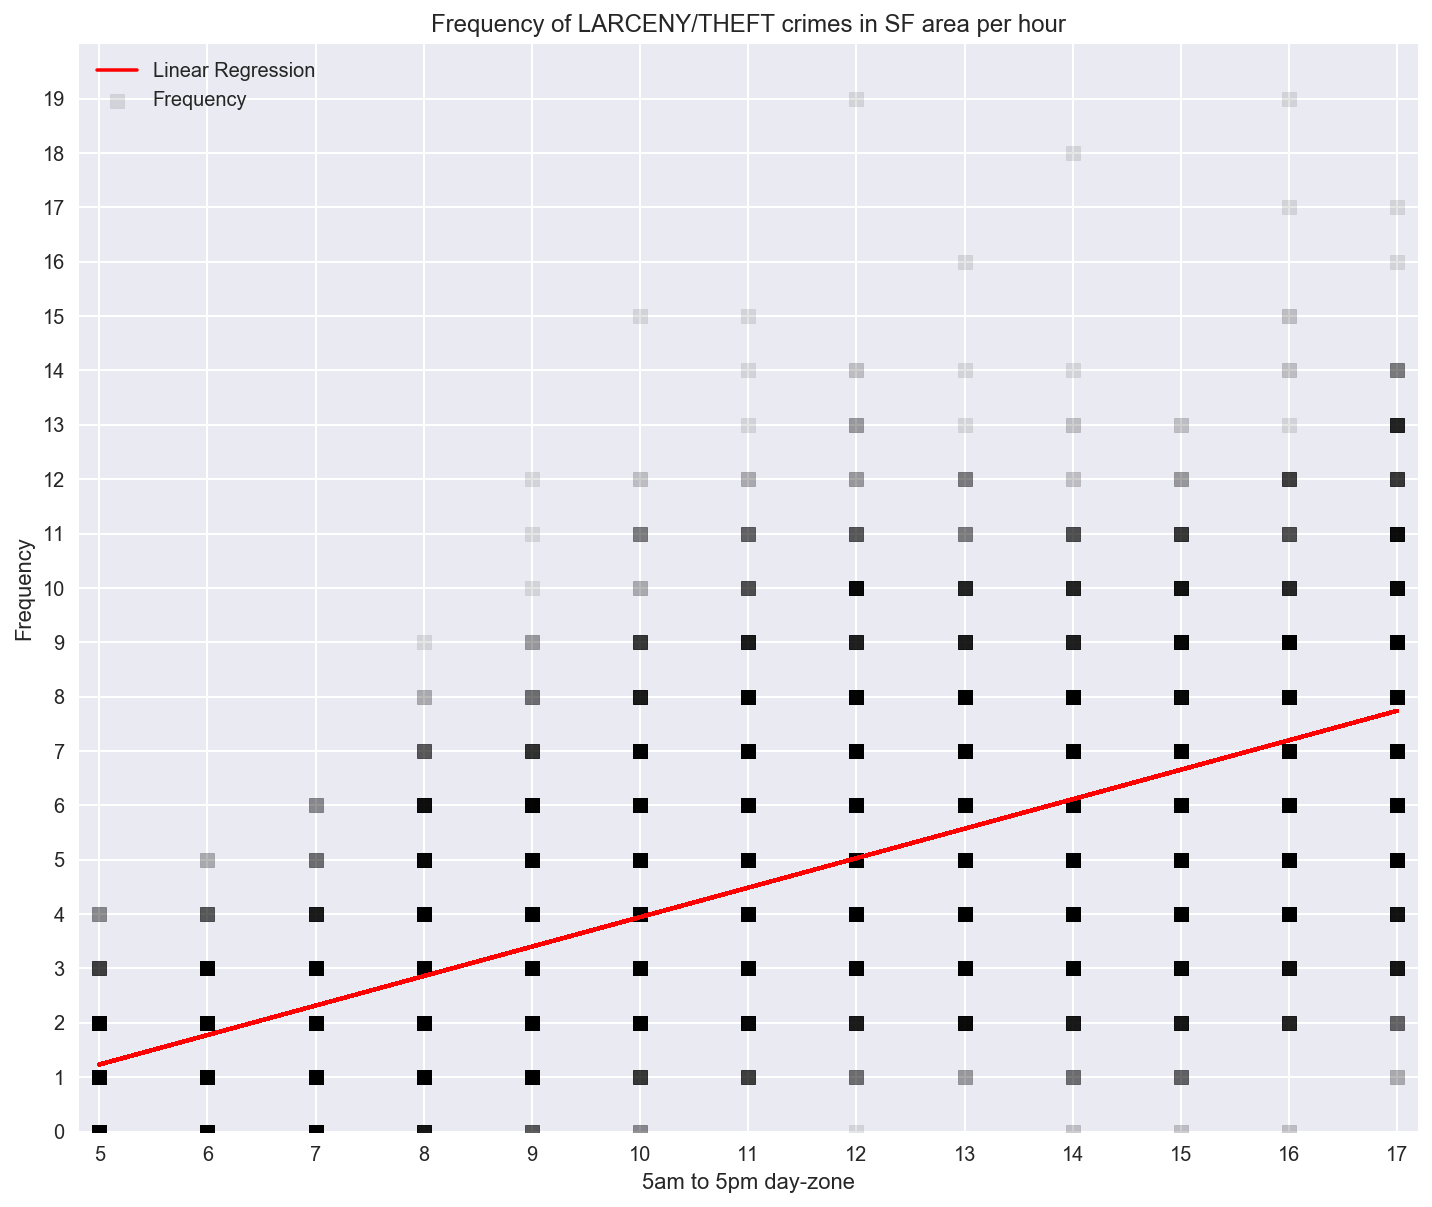

In [21]:
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from sklearn import linear_model

# Assign x and y values
features = np.array(df_2016_merge['Hour']).reshape(-1,1)
labels = np.array(df_2016_merge['day_hour_count'])

# Fit the linear Regression model
lm = linear_model.LinearRegression()
lm.fit(features, labels)
pred = lm.predict(features)

plt.figure(figsize=(12,10))
plt.plot(features,pred,'r-',label='Linear Regression')

#Plotting the scatter plot
# Give the x and y values to the scatterplot and the regression line
plt.scatter(df_2016_merge['Hour'], df_2016_merge['day_hour_count'], color='black',marker='s', alpha=.1,label='Frequency')

# Give labels and titles
plt.ylabel("Frequency")
plt.title("Frequency of LARCENY/THEFT crimes in SF area per hour")
plt.xticks(range(5,18,1))
plt.yticks(range(0,20))
plt.xlabel("5am to 5pm day-zone")

#Set margins
plt.margins(0.01,0)
plt.ylim(0,20)

plt.legend()
plt.show()

In [22]:
from scipy.stats.stats import pearsonr
from prettytable import PrettyTable

print 'Pearson Correlation  \t-->\t%.10f' % pearsonr(np.array(df_2016_merge['Hour']),labels)[0]

beta = lm.coef_[0]
alpha = lm.intercept_
x = PrettyTable()
x.field_names= ['Slope (beta)','Intercept (alpha)']
x.add_row([beta,alpha])
print x

Pearson Correlation  	-->	0.6548363824
+----------------+-------------------+
|  Slope (beta)  | Intercept (alpha) |
+----------------+-------------------+
| 0.542349726776 |   -1.47971836906  |
+----------------+-------------------+


## 3. Multiple Regression
*Let's improve the model by incorporating the total amount of crime in the area we're considering.*

*The more general model with $k$ input variables is described as*
$$y_i = \alpha + \beta_1x_{i1} + \ldots + \beta_k x_{ik} + \epsilon_i.$$
*We will be looking at the case when $k=2$, so our model is simply*
$$y_i = \alpha + \beta_1x_{i1} + \beta_2 x_{i2} + \epsilon_i.$$

*In our example, we want to include **both** the **time of day** (as above) and the **total amount of crime** in our model. This means that the $(x_{i1}, x_{i2}, y_{i})$ variables in the model has the following correspondence:*
* $x_{i1}$ *corresponds to time-of-day (input variable)*
* $x_{i2}$ *corresponds to total amount of crime in the area (input variable)*
* $y_i$ *corresponds to the number of LARCENY/THEFT crimes in that bin (output variable)*

*As above, one observation is a $(x_{i1}, x_{i2}, y_{i})$ and you should have 12 for each day in the dataset.*

*In order to make the model useful, you have transform your input variables a bit before fitting:*
* *Firstly, instead of using total crime vs. the crime we're considering, remember to use differences between average total crime and observed crime.*
* *Secondly, remember to rescale your input variables.*

*Explain in your own words the reasoning between the two bullets above.*

*Finally, create and fit the data set using multiple regression. Report $\alpha, \beta_1, \beta_2$.*

In [24]:
# Starting point
#display(df_2016_merge.head())

df_total_crimes_per_hour = df_2016_merge.groupby('Hour')['day_hour_count'].sum().reset_index(name='total_hour_count').sort_values(by='Hour',ascending=True)
#display(df_total_crimes_per_hour.head())

# Merge the previously created dataframe with the one we started from
df_2016_merge = pd.merge(df_2016_merge,
                          df_total_crimes_per_hour,on='Hour',how='left')
#display(df_2016_merge.head())

#Create a column with the average number of crimes for each (day-hour) bin
df_2016_merge['avg_total_hour_count'] = df_2016_merge['total_hour_count']/num_days_per_year

#We can drop the total_hour_count column, since we won't need it anymore
df_2016_merge = df_2016_merge.drop(['total_hour_count'],axis=1)
#display(df_2016_merge.head())

#Calculating the difference
df_2016_merge['diff'] = df_2016_merge['avg_total_hour_count']-df_2016_merge['day_hour_count']
display(df_2016_merge.head())

Date  Hour  day_hour_count  avg_total_hour_count      diff
0  01/01/2016     5             1.0              0.822404 -0.177596
1  01/01/2016     6             1.0              1.199454  0.199454
2  01/01/2016     7             2.0              1.685792 -0.314208
3  01/01/2016     8             0.0              2.978142  2.978142
4  01/01/2016     9             1.0              3.535519  2.535519

In [25]:
#Assign x and y values
features = np.array(df_2016_merge[['Hour','diff']])
labels = np.array(df_2016_merge['day_hour_count'])

# Fit the linear Regression model
mlr = linear_model.LinearRegression(normalize=True)
mlr.fit(features, labels)
pred = mlr.predict(features)
beta1 = mlr.coef_[0]
beta2 = mlr.coef_[1]
alpha = mlr.intercept_

#Printing coefficients and score
x = PrettyTable()
x.field_names = ['Score','Beta_1','Beta_2','Alpha']
x.add_row([mlr.score(features,labels),beta1,beta2,alpha])
print x

+----------------+----------------+--------+----------------+
|     Score      |     Beta_1     | Beta_2 |     Alpha      |
+----------------+----------------+--------+----------------+
| 0.960760249024 | 0.542349726776 |  -1.0  | -1.47971836906 |
+----------------+----------------+--------+----------------+


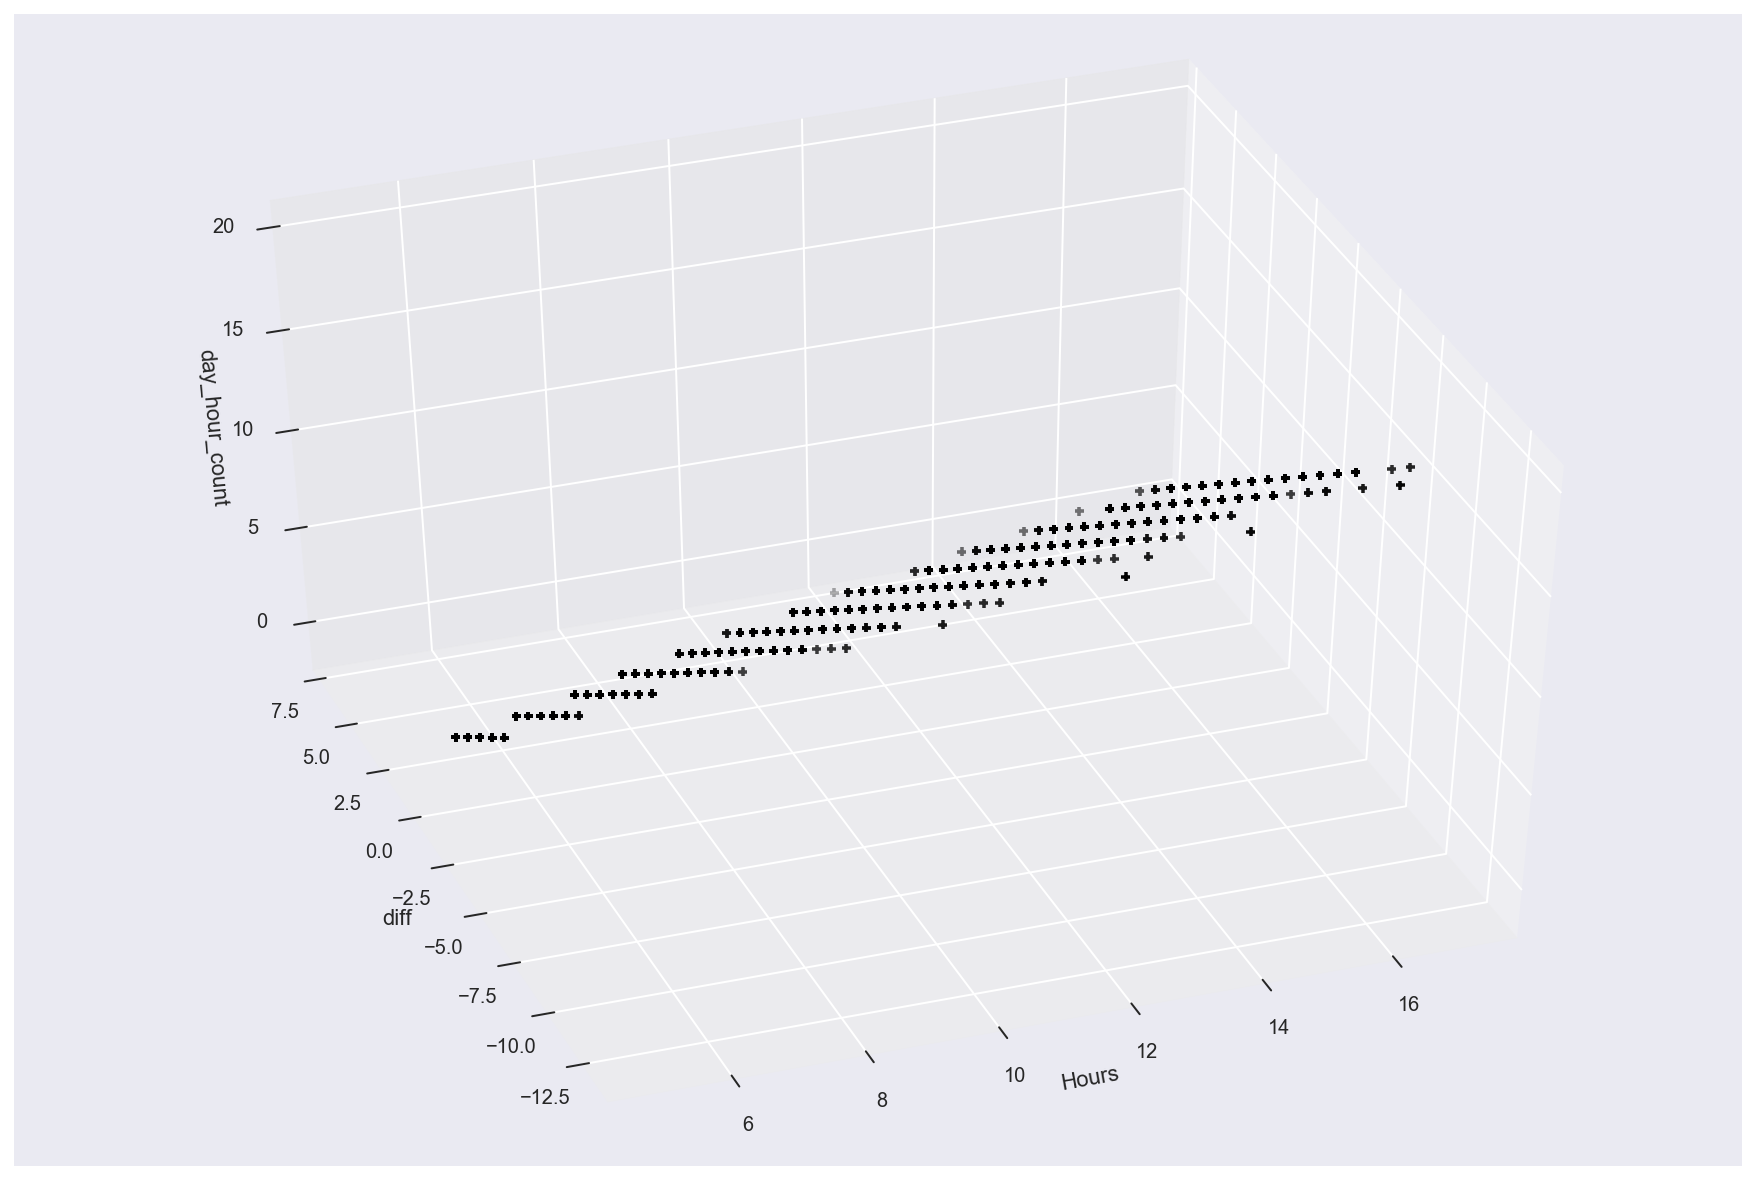

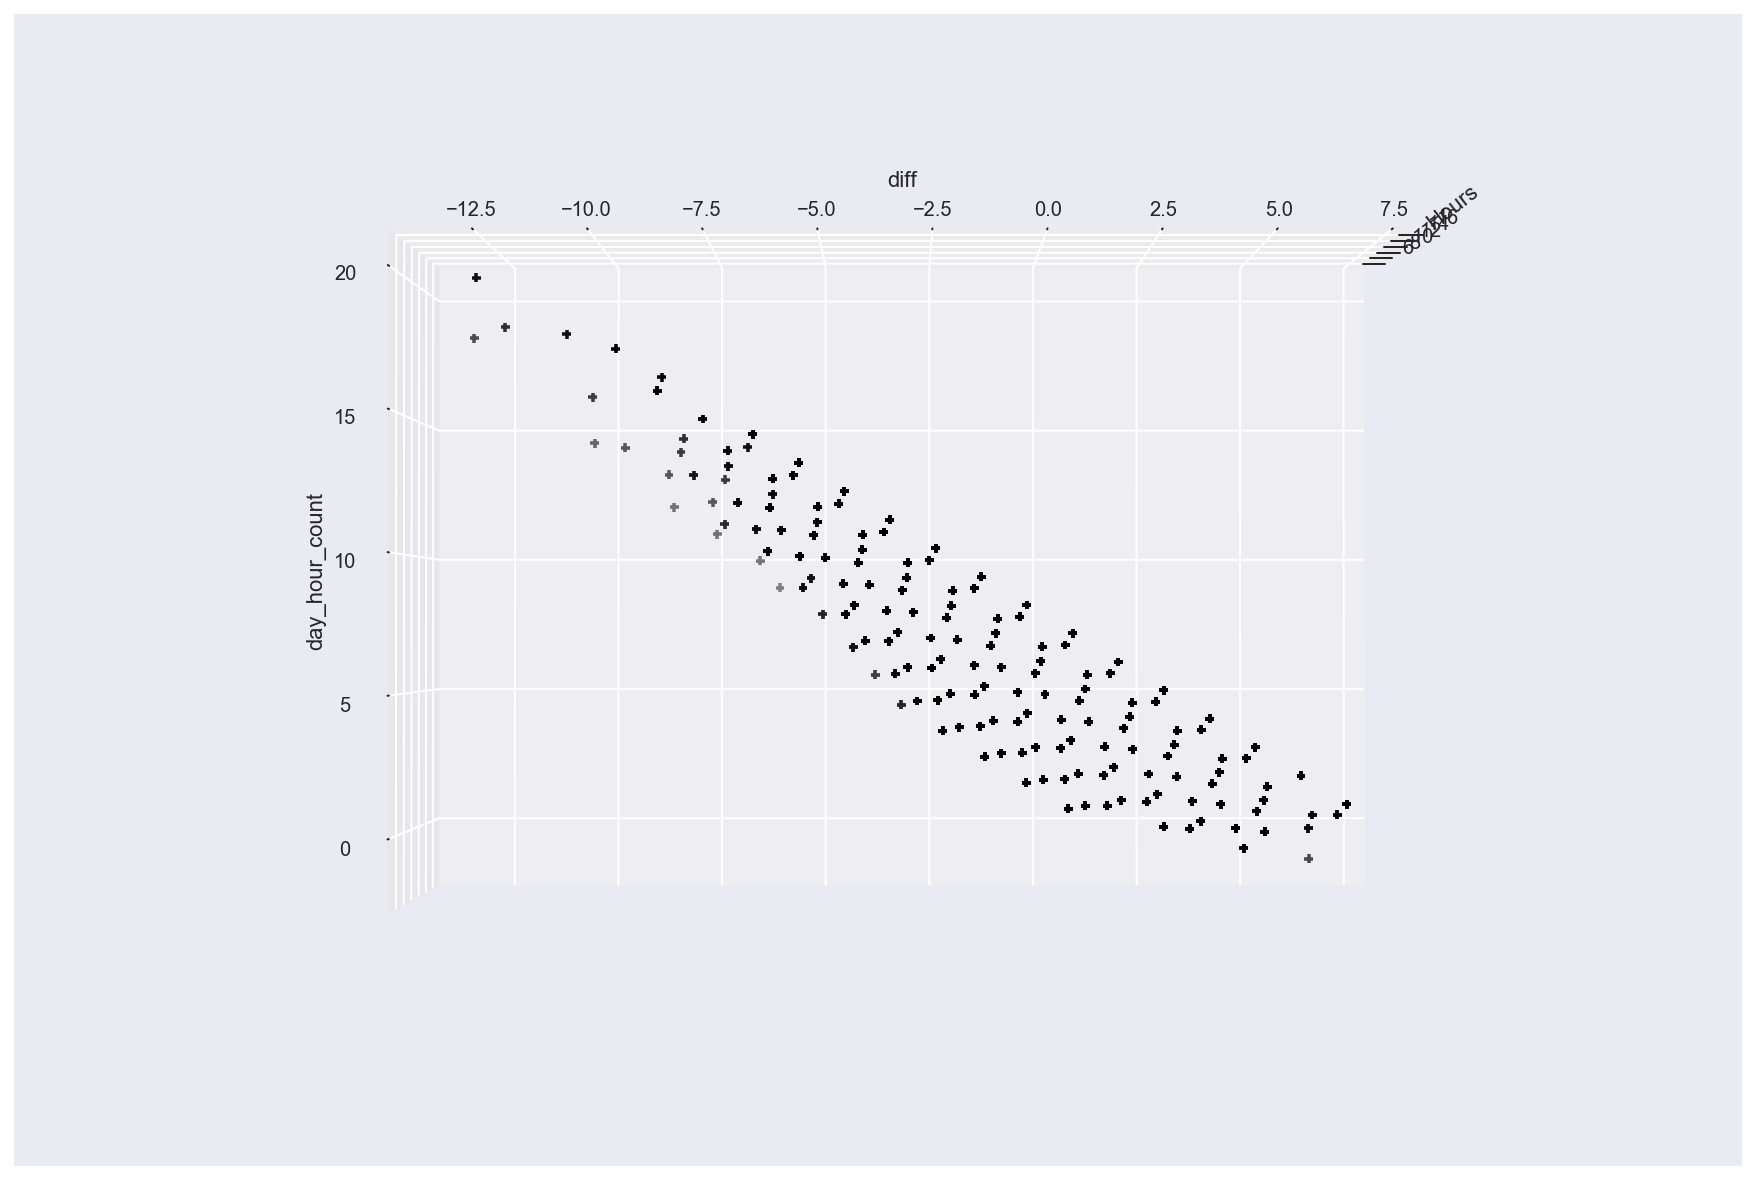

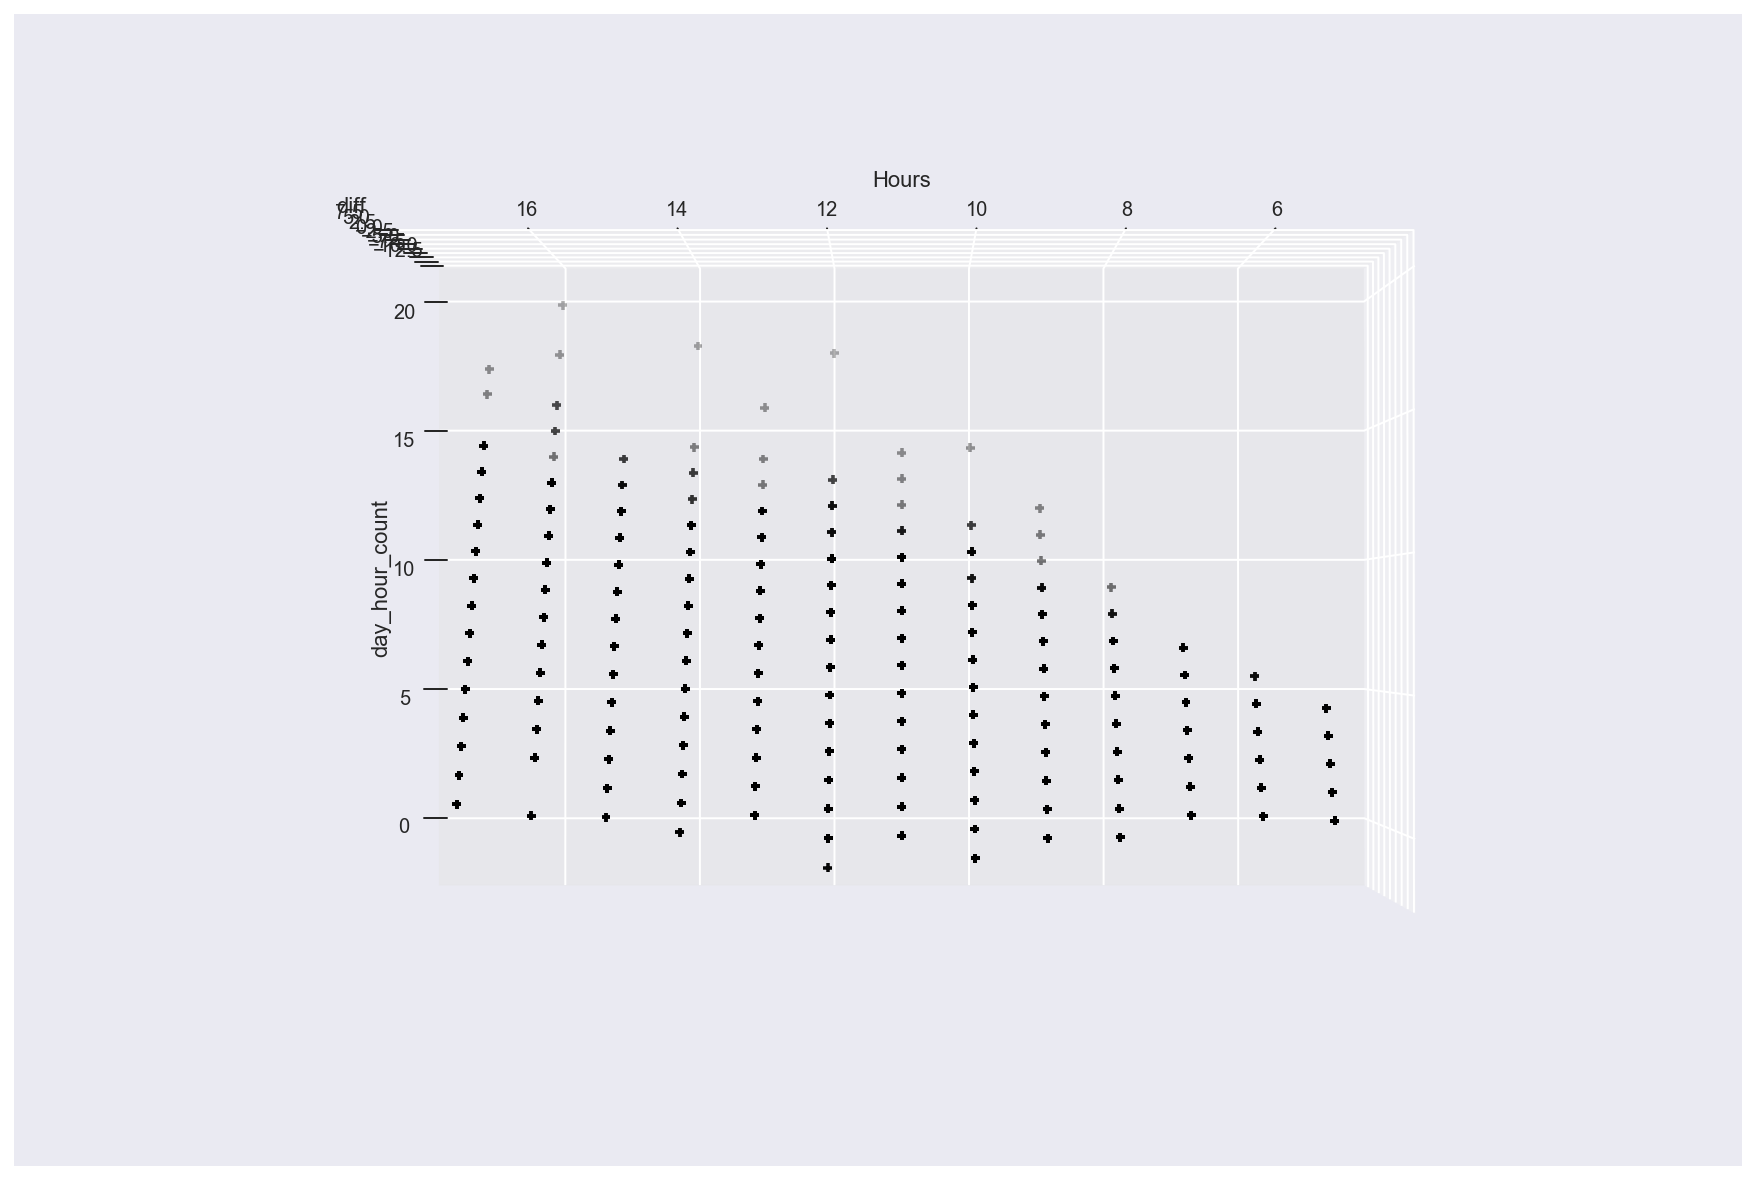

In [27]:
from mpl_toolkits.mplot3d import Axes3D

# Plot the 3D figure
def plot_figs(fig_num, elev, azim, features, clf):
    fig = plt.figure(fig_num, figsize=(12, 8))
    plt.clf()
    ax = Axes3D(fig, elev=elev, azim=azim)

    ax.scatter(features[:, 0], features[:, 1], clf.predict(features), c='k', marker='+')
    
    ax.set_xlabel('Hours')
    ax.set_ylabel('diff')
    ax.set_zlabel('day_hour_count')
    #ax.w_xaxis.set_ticklabels(range(5,18,1))
    #ax.w_yaxis.set_ticklabels([])
    #ax.w_zaxis.set_ticklabels([])

#Generate the three different figures from different views
elev = 43.5
azim = -110
plot_figs(1, elev, azim, features, mlr)

elev = -.5
azim = 0
plot_figs(2, elev, azim, features, mlr)

elev = -.5
azim = 90
plot_figs(3, elev, azim, features, mlr)

plt.show()

## 4. Evaluation
Compare the accuracy of the simple linear regression with the multiple regression to see what we have gained by increasing the model complexity. We test on two separate weeks of data from 2016. We use the first 7 days (Week A) of January 2016 and first 7 days of June 2016 (Week B). We measure error for a time-bin simply as the absolute difference between predicted crime and observed crime. The error for a week is simply the average error over all time-bins during that week.
* Report the performance of Simple & Multiple Regression for Weeks A & B (four results total).

In [28]:
def get_month(date):
    return int(date.split('/')[1].lstrip('0'))

def get_day(date):
    return int(date.split('/')[0].lstrip('0'))

df_2016_merge['Day'] = df_2016_merge['Date'].apply(lambda x: get_day(x))
df_2016_merge['Month'] = df_2016_merge['Date'].apply(lambda x: get_month(x))

week_A = df_2016_merge[(df_2016_merge['Month']==1)&(df_2016_merge['Day']>=1)&(df_2016_merge['Day']<=7)]
week_B = df_2016_merge[(df_2016_merge['Month']==6)&(df_2016_merge['Day']>=1)&(df_2016_merge['Day']<=7)]

### Linear regression

In [29]:
def linear_model_evaluation(week,week_name):
    training_set = df_2016_merge.drop(week.index) #Training set = Total - Test Set
    features_training_set = training_set['Hour'] #Extract the single feature for LR
    labels_training_set = training_set['day_hour_count'] #Extract labels/classes
    features_test_set = week['Hour']
    
    #Let's recall features and labels for the linear regression
    features_lr = np.array(features_training_set).reshape(-1,1)
    labels_lr = np.array(labels_training_set)
    lm.fit(features_lr,labels_lr)
    pred = lm.predict(np.array(features_test_set).reshape(-1,1))
    
    df_prediction = week
    df_prediction['lr_pred'] = pred
    df_prediction['lr_error'] = abs(df_prediction['lr_pred']-df_prediction['day_hour_count'])
    average_week_error = df_prediction['lr_error'].mean()
    print '%s Linear Regression Average Error \t-->\t %f' %(week_name,average_week_error)

for week,week_name in [(week_A,'Week A'),(week_B,'Week B')]:
    linear_model_evaluation(week,week_name)

Week A Linear Regression Average Error 	-->	 2.041662
Week B Linear Regression Average Error 	-->	 1.824416


### Multiple Regression

In [30]:
def multiple_regression_model_evaluation(week,week_name):
    training_set = df_2016_merge.drop(week.index)
    features_training_set = training_set[['Hour','diff']]
    labels_training_set = training_set['day_hour_count']
    features_test_set = week[['Hour','diff']]

    labels_mlr = np.array(labels_training_set)
    mlr.fit(features_training_set,labels_mlr)
    pred = mlr.predict(features_test_set)

    df_prediction = week
    df_prediction['mlr_pred'] = pred
    df_prediction['mlr_error'] = abs(df_prediction['mlr_pred']-df_prediction['day_hour_count'])
    average_week_error = df_prediction['mlr_error'].mean()
    print '%s Multiple Regression Average Error \t-->\t %f' %(week_name,average_week_error)
    
for week,week_name in [(week_A,'Week A'),(week_B,'Week B')]:
    multiple_regression_model_evaluation(week,week_name)

Week A Multiple Regression Average Error 	-->	 0.523047
Week B Multiple Regression Average Error 	-->	 0.522896
